In [16]:
pip install tensorflow matplotlib pandas tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 3.3 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip


KeyboardInterrupt



In [ ]:
!unzip -q kagglecatsanddogs_5340.zip
!ls

In [ ]:
!ls PetImages

In [4]:
import os

num_skipped = 0
images_paths = []
for folder_name in ["Cat", "Dog"]:
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()
            
        if not is_jfif:
            num_skipped += 1
            os.remove(fpath)
        else:
            images_paths.append(fpath)

In [11]:
len(images_paths)

23412

In [9]:
num_skipped

1590

In [13]:
from PIL import Image
img = Image.open(images_paths[0])
img.size

(500, 375)

In [17]:
import matplotlib.pyplot as plt
from tqdm import tqdm

heights = []
widths = []
for image_path in tqdm(images_paths):
    try:
        img = Image.open(image_path)
    except:
        print("Failed to load image")
    height, width = img.size
    heights.append(height)
    widths.append(width)

 55%|█████▍    | 12870/23412 [00:01<00:01, 7433.52it/s]

Failed to load image


100%|██████████| 23412/23412 [00:03<00:00, 7120.23it/s]

Failed to load image


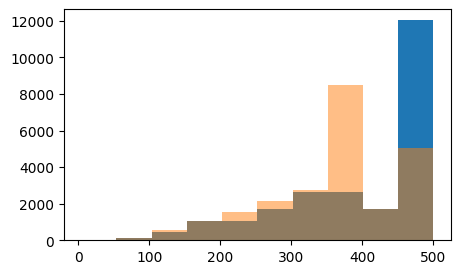

In [23]:
plt.figure(figsize=(5, 3))
plt.hist(heights)
plt.hist(widths, alpha=.5)
plt.show()

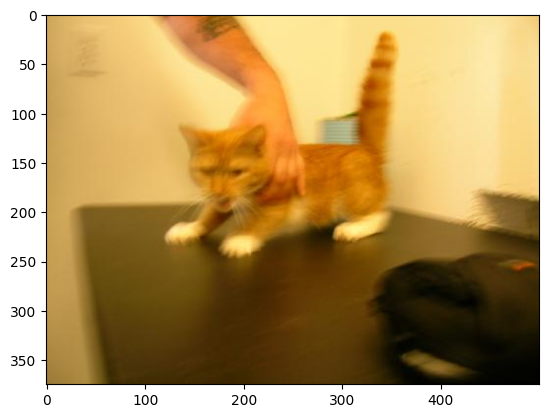

In [24]:
img = Image.open(images_paths[0])

plt.imshow(img)

In [26]:
resized_img = img.resize((100, 100))

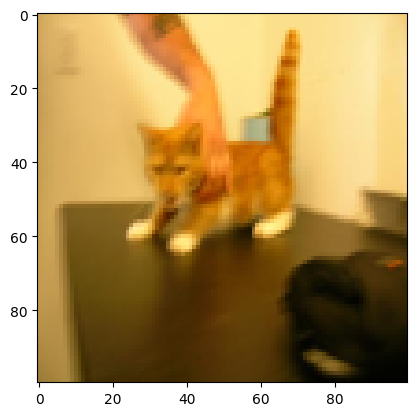

In [27]:
plt.imshow(resized_img)

In [5]:
image_size = (180, 180)
batch_size = 64

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=48,
    image_size=image_size,
    batch_size=batch_size
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


2023-08-04 15:23:32.530747: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10216 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:06:00.0, compute capability: 8.6


In [79]:
train_ds.class_names

['Cat', 'Dog']

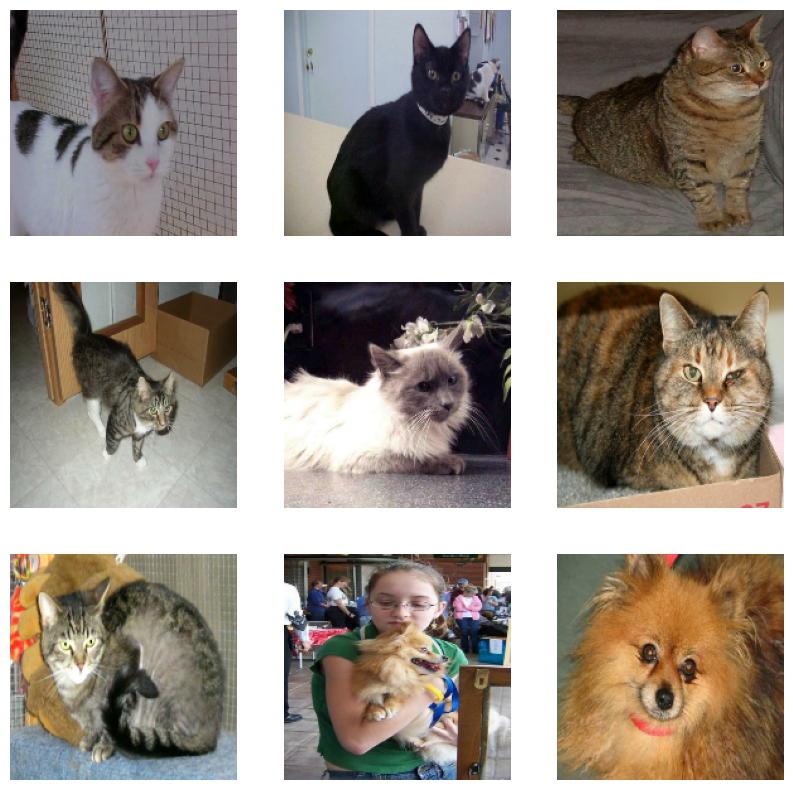

In [80]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(1, 10):
        ax = plt.subplot(3, 3, i)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

In [82]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1)
    ]
)

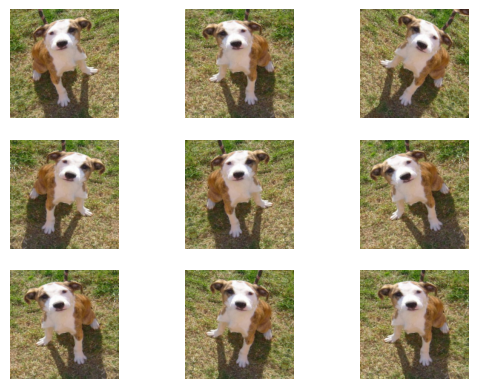

In [83]:
for images, labels in train_ds.take(1):
    for i in range(1, 10):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [84]:
next(iter(train_ds.take(1)))[0].shape

TensorShape([32, 180, 180, 3])

In [6]:
input_shape = (180, 180)
inputs = keras.Input(shape=input_shape)

x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

NameError: name 'data_augmentation' is not defined

In [ ]:
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE
)

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [7]:
def make_model(input_shape, num_classes):
    inputs = keras.layers.Input(shape=input_shape)
    
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    previous_block_activation = x
    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
        
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
        
        x = layers.add([x, residual])
        previous_block_activation = x
        
    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

In [8]:
input_shape

(180, 180)

In [9]:
model = make_model(input_shape=input_shape + (3,), num_classes=2)

In [10]:
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [11]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras")
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [12]:
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds
)

Epoch 1/25


2023-08-04 15:23:55.073068: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-04 15:23:58.749361: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-08-04 15:23:58.749864: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fce5fc35110 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-04 15:23:58.749892: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2023-08-04 15:23:58.755982: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-04 15:23:58.938272: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

  9/293 [..............................] - ETA: 1:31 - loss: 0.7952 - accuracy: 0.5833

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 51/293 [====>.........................] - ETA: 1:18 - loss: 0.7149 - accuracy: 0.5913

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 77/293 [======>.......................] - ETA: 1:09 - loss: 0.6995 - accuracy: 0.6039

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


133/293 [============>.................] - ETA: 51s - loss: 0.6814 - accuracy: 0.6170

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


149/293 [==============>...............] - ETA: 46s - loss: 0.6756 - accuracy: 0.6228

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


154/293 [==============>...............] - ETA: 44s - loss: 0.6726 - accuracy: 0.6261

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


171/293 [================>.............] - ETA: 39s - loss: 0.6658 - accuracy: 0.6310

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


185/293 [=================>............] - ETA: 34s - loss: 0.6590 - accuracy: 0.6364

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


186/293 [==================>...........] - ETA: 34s - loss: 0.6588 - accuracy: 0.6368

278/293 [===========================>..] - ETA: 4s - loss: 0.6273 - accuracy: 0.6642

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


293/293 [==============================] - ETA: 0s - loss: 0.6235 - accuracy: 0.6677

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


293/293 [==============================] - 132s 374ms/step - loss: 0.6235 - accuracy: 0.6677 - val_loss: 0.9757 - val_accuracy: 0.5049
Epoch 2/25
  9/293 [..............................] - ETA: 1:32 - loss: 0.5281 - accuracy: 0.7344

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 51/293 [====>.........................] - ETA: 1:18 - loss: 0.4984 - accuracy: 0.7616

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 77/293 [======>.......................] - ETA: 1:10 - loss: 0.4989 - accuracy: 0.7618

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


133/293 [============>.................] - ETA: 51s - loss: 0.4978 - accuracy: 0.7642

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


149/293 [==============>...............] - ETA: 46s - loss: 0.4920 - accuracy: 0.7666

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


154/293 [==============>...............] - ETA: 45s - loss: 0.4908 - accuracy: 0.7671

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


171/293 [================>.............] - ETA: 39s - loss: 0.4913 - accuracy: 0.7667

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


185/293 [=================>............] - ETA: 35s - loss: 0.4870 - accuracy: 0.7682

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


186/293 [==================>...........] - ETA: 34s - loss: 0.4863 - accuracy: 0.7686

278/293 [===========================>..] - ETA: 4s - loss: 0.4677 - accuracy: 0.7804

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


293/293 [==============================] - ETA: 0s - loss: 0.4663 - accuracy: 0.7815

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


293/293 [==============================] - 103s 351ms/step - loss: 0.4663 - accuracy: 0.7815 - val_loss: 1.0652 - val_accuracy: 0.5113
Epoch 3/25
  9/293 [..............................] - ETA: 1:32 - loss: 0.4230 - accuracy: 0.8177

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 51/293 [====>.........................] - ETA: 1:18 - loss: 0.3952 - accuracy: 0.8244

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 77/293 [======>.......................] - ETA: 1:10 - loss: 0.3998 - accuracy: 0.8231

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


133/293 [============>.................] - ETA: 51s - loss: 0.3945 - accuracy: 0.8257

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


149/293 [==============>...............] - ETA: 46s - loss: 0.3908 - accuracy: 0.8273

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


154/293 [==============>...............] - ETA: 45s - loss: 0.3900 - accuracy: 0.8276

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


171/293 [================>.............] - ETA: 39s - loss: 0.3841 - accuracy: 0.8308

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


185/293 [=================>............] - ETA: 35s - loss: 0.3800 - accuracy: 0.8332

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


186/293 [==================>...........] - ETA: 34s - loss: 0.3788 - accuracy: 0.8338

278/293 [===========================>..] - ETA: 4s - loss: 0.3608 - accuracy: 0.8430

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


293/293 [==============================] - ETA: 0s - loss: 0.3567 - accuracy: 0.8450

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


293/293 [==============================] - 103s 351ms/step - loss: 0.3567 - accuracy: 0.8450 - val_loss: 0.3616 - val_accuracy: 0.8398
Epoch 4/25
  9/293 [..............................] - ETA: 1:32 - loss: 0.3049 - accuracy: 0.8611

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 51/293 [====>.........................] - ETA: 1:18 - loss: 0.2843 - accuracy: 0.8802

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 77/293 [======>.......................] - ETA: 1:10 - loss: 0.2955 - accuracy: 0.8762

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


133/293 [============>.................] - ETA: 51s - loss: 0.3007 - accuracy: 0.8748

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


149/293 [==============>...............] - ETA: 46s - loss: 0.2960 - accuracy: 0.8767

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


154/293 [==============>...............] - ETA: 45s - loss: 0.2940 - accuracy: 0.8775

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


171/293 [================>.............] - ETA: 39s - loss: 0.2900 - accuracy: 0.8797

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


185/293 [=================>............] - ETA: 35s - loss: 0.2864 - accuracy: 0.8814

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


186/293 [==================>...........] - ETA: 34s - loss: 0.2864 - accuracy: 0.8814

278/293 [===========================>..] - ETA: 4s - loss: 0.2705 - accuracy: 0.8874

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


293/293 [==============================] - ETA: 0s - loss: 0.2688 - accuracy: 0.8878

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


293/293 [==============================] - 103s 351ms/step - loss: 0.2688 - accuracy: 0.8878 - val_loss: 0.9272 - val_accuracy: 0.6867
Epoch 5/25
  9/293 [..............................] - ETA: 1:32 - loss: 0.2077 - accuracy: 0.9236

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 51/293 [====>.........................] - ETA: 1:18 - loss: 0.2221 - accuracy: 0.9062

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 77/293 [======>.......................] - ETA: 1:10 - loss: 0.2220 - accuracy: 0.9071

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


133/293 [============>.................] - ETA: 51s - loss: 0.2269 - accuracy: 0.9071

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


149/293 [==============>...............] - ETA: 46s - loss: 0.2230 - accuracy: 0.9088

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


154/293 [==============>...............] - ETA: 45s - loss: 0.2212 - accuracy: 0.9096

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


171/293 [================>.............] - ETA: 39s - loss: 0.2164 - accuracy: 0.9120

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


185/293 [=================>............] - ETA: 35s - loss: 0.2143 - accuracy: 0.9131

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


186/293 [==================>...........] - ETA: 34s - loss: 0.2138 - accuracy: 0.9134

278/293 [===========================>..] - ETA: 4s - loss: 0.2075 - accuracy: 0.9154

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


293/293 [==============================] - ETA: 0s - loss: 0.2055 - accuracy: 0.9160

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


293/293 [==============================] - 103s 351ms/step - loss: 0.2055 - accuracy: 0.9160 - val_loss: 0.4447 - val_accuracy: 0.7868
Epoch 6/25
  9/293 [..............................] - ETA: 1:32 - loss: 0.1739 - accuracy: 0.9271

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 51/293 [====>.........................] - ETA: 1:18 - loss: 0.1820 - accuracy: 0.9289

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 77/293 [======>.......................] - ETA: 1:10 - loss: 0.1821 - accuracy: 0.9278

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


133/293 [============>.................] - ETA: 51s - loss: 0.1829 - accuracy: 0.9274

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


149/293 [==============>...............] - ETA: 46s - loss: 0.1808 - accuracy: 0.9283

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


154/293 [==============>...............] - ETA: 45s - loss: 0.1789 - accuracy: 0.9294

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


171/293 [================>.............] - ETA: 39s - loss: 0.1738 - accuracy: 0.9322

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


185/293 [=================>............] - ETA: 35s - loss: 0.1709 - accuracy: 0.9334

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


186/293 [==================>...........] - ETA: 34s - loss: 0.1703 - accuracy: 0.9336

278/293 [===========================>..] - ETA: 4s - loss: 0.1597 - accuracy: 0.9387

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


293/293 [==============================] - ETA: 0s - loss: 0.1591 - accuracy: 0.9388

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


293/293 [==============================] - 103s 350ms/step - loss: 0.1591 - accuracy: 0.9388 - val_loss: 0.2330 - val_accuracy: 0.9030
Epoch 7/25
  9/293 [..............................] - ETA: 1:32 - loss: 0.1072 - accuracy: 0.9618

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 51/293 [====>.........................] - ETA: 1:18 - loss: 0.1246 - accuracy: 0.9519

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 77/293 [======>.......................] - ETA: 1:10 - loss: 0.1260 - accuracy: 0.9505

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


133/293 [============>.................] - ETA: 51s - loss: 0.1283 - accuracy: 0.9483

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


149/293 [==============>...............] - ETA: 46s - loss: 0.1285 - accuracy: 0.9481

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


154/293 [==============>...............] - ETA: 45s - loss: 0.1275 - accuracy: 0.9488

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


171/293 [================>.............] - ETA: 39s - loss: 0.1268 - accuracy: 0.9488

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


185/293 [=================>............] - ETA: 35s - loss: 0.1266 - accuracy: 0.9488

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


186/293 [==================>...........] - ETA: 34s - loss: 0.1262 - accuracy: 0.9490

278/293 [===========================>..] - ETA: 4s - loss: 0.1206 - accuracy: 0.9507

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


293/293 [==============================] - ETA: 0s - loss: 0.1203 - accuracy: 0.9509

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


293/293 [==============================] - 103s 350ms/step - loss: 0.1203 - accuracy: 0.9509 - val_loss: 0.2089 - val_accuracy: 0.9161
Epoch 8/25
  9/293 [..............................] - ETA: 1:31 - loss: 0.0832 - accuracy: 0.9722

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 51/293 [====>.........................] - ETA: 1:18 - loss: 0.0942 - accuracy: 0.9651

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 77/293 [======>.......................] - ETA: 1:09 - loss: 0.1019 - accuracy: 0.9621

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


133/293 [============>.................] - ETA: 51s - loss: 0.1080 - accuracy: 0.9590

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


149/293 [==============>...............] - ETA: 46s - loss: 0.1067 - accuracy: 0.9590

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


154/293 [==============>...............] - ETA: 45s - loss: 0.1060 - accuracy: 0.9593

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


171/293 [================>.............] - ETA: 39s - loss: 0.1035 - accuracy: 0.9600

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


185/293 [=================>............] - ETA: 35s - loss: 0.1007 - accuracy: 0.9608

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


186/293 [==================>...........] - ETA: 34s - loss: 0.1004 - accuracy: 0.9609

278/293 [===========================>..] - ETA: 4s - loss: 0.0988 - accuracy: 0.9616

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


293/293 [==============================] - ETA: 0s - loss: 0.0976 - accuracy: 0.9624

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


293/293 [==============================] - 103s 351ms/step - loss: 0.0976 - accuracy: 0.9624 - val_loss: 0.5979 - val_accuracy: 0.8238
Epoch 9/25
  9/293 [..............................] - ETA: 1:32 - loss: 0.0862 - accuracy: 0.9722

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 51/293 [====>.........................] - ETA: 1:18 - loss: 0.0931 - accuracy: 0.9666

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 77/293 [======>.......................] - ETA: 1:10 - loss: 0.0922 - accuracy: 0.9665

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


133/293 [============>.................] - ETA: 51s - loss: 0.0981 - accuracy: 0.9645

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


149/293 [==============>...............] - ETA: 46s - loss: 0.0963 - accuracy: 0.9652

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


154/293 [==============>...............] - ETA: 45s - loss: 0.0970 - accuracy: 0.9648

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


171/293 [================>.............] - ETA: 39s - loss: 0.0942 - accuracy: 0.9658

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


185/293 [=================>............] - ETA: 35s - loss: 0.0932 - accuracy: 0.9660

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


186/293 [==================>...........] - ETA: 34s - loss: 0.0943 - accuracy: 0.9654

278/293 [===========================>..] - ETA: 4s - loss: 0.0928 - accuracy: 0.9646

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


293/293 [==============================] - ETA: 0s - loss: 0.0917 - accuracy: 0.9650

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


293/293 [==============================] - 103s 351ms/step - loss: 0.0917 - accuracy: 0.9650 - val_loss: 0.2139 - val_accuracy: 0.9133
Epoch 10/25
  9/293 [..............................] - ETA: 1:32 - loss: 0.0484 - accuracy: 0.9826

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 51/293 [====>.........................] - ETA: 1:18 - loss: 0.0765 - accuracy: 0.9700

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 77/293 [======>.......................] - ETA: 1:10 - loss: 0.0780 - accuracy: 0.9702

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


133/293 [============>.................] - ETA: 51s - loss: 0.0769 - accuracy: 0.9716

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


149/293 [==============>...............] - ETA: 46s - loss: 0.0761 - accuracy: 0.9721

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


154/293 [==============>...............] - ETA: 45s - loss: 0.0753 - accuracy: 0.9725

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


171/293 [================>.............] - ETA: 39s - loss: 0.0729 - accuracy: 0.9729

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


185/293 [=================>............] - ETA: 35s - loss: 0.0715 - accuracy: 0.9735

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


186/293 [==================>...........] - ETA: 34s - loss: 0.0715 - accuracy: 0.9735

278/293 [===========================>..] - ETA: 4s - loss: 0.0674 - accuracy: 0.9752

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


293/293 [==============================] - ETA: 0s - loss: 0.0670 - accuracy: 0.9753

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


293/293 [==============================] - 103s 351ms/step - loss: 0.0670 - accuracy: 0.9753 - val_loss: 0.1872 - val_accuracy: 0.9276
Epoch 11/25
  9/293 [..............................] - ETA: 1:32 - loss: 0.0787 - accuracy: 0.9705

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 51/293 [====>.........................] - ETA: 1:18 - loss: 0.0583 - accuracy: 0.9770

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 77/293 [======>.......................] - ETA: 1:10 - loss: 0.0578 - accuracy: 0.9775

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


133/293 [============>.................] - ETA: 51s - loss: 0.0657 - accuracy: 0.9751

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


149/293 [==============>...............] - ETA: 46s - loss: 0.0650 - accuracy: 0.9754

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


154/293 [==============>...............] - ETA: 45s - loss: 0.0642 - accuracy: 0.9758

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


171/293 [================>.............] - ETA: 39s - loss: 0.0639 - accuracy: 0.9758

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


185/293 [=================>............] - ETA: 35s - loss: 0.0615 - accuracy: 0.9770

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


186/293 [==================>...........] - ETA: 34s - loss: 0.0617 - accuracy: 0.9771

278/293 [===========================>..] - ETA: 4s - loss: 0.0615 - accuracy: 0.9769

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


293/293 [==============================] - ETA: 0s - loss: 0.0614 - accuracy: 0.9770

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


293/293 [==============================] - 103s 350ms/step - loss: 0.0614 - accuracy: 0.9770 - val_loss: 0.2609 - val_accuracy: 0.9090
Epoch 12/25
  9/293 [..............................] - ETA: 1:32 - loss: 0.0482 - accuracy: 0.9809

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 51/293 [====>.........................] - ETA: 1:18 - loss: 0.0651 - accuracy: 0.9737

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 77/293 [======>.......................] - ETA: 1:10 - loss: 0.0638 - accuracy: 0.9754

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


133/293 [============>.................] - ETA: 51s - loss: 0.0594 - accuracy: 0.9785

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


149/293 [==============>...............] - ETA: 46s - loss: 0.0564 - accuracy: 0.9794

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


154/293 [==============>...............] - ETA: 45s - loss: 0.0562 - accuracy: 0.9795

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


171/293 [================>.............] - ETA: 39s - loss: 0.0544 - accuracy: 0.9804

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


185/293 [=================>............] - ETA: 35s - loss: 0.0542 - accuracy: 0.9804

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


186/293 [==================>...........] - ETA: 34s - loss: 0.0541 - accuracy: 0.9804

278/293 [===========================>..] - ETA: 4s - loss: 0.0519 - accuracy: 0.9807

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


293/293 [==============================] - ETA: 0s - loss: 0.0510 - accuracy: 0.9810

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


293/293 [==============================] - 103s 350ms/step - loss: 0.0510 - accuracy: 0.9810 - val_loss: 0.1897 - val_accuracy: 0.9280
Epoch 13/25
  9/293 [..............................] - ETA: 1:32 - loss: 0.0496 - accuracy: 0.9809

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 51/293 [====>.........................] - ETA: 1:18 - loss: 0.0404 - accuracy: 0.9847

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 77/293 [======>.......................] - ETA: 1:10 - loss: 0.0424 - accuracy: 0.9848

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


133/293 [============>.................] - ETA: 51s - loss: 0.0454 - accuracy: 0.9838

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


149/293 [==============>...............] - ETA: 46s - loss: 0.0468 - accuracy: 0.9831

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


154/293 [==============>...............] - ETA: 45s - loss: 0.0487 - accuracy: 0.9827

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


171/293 [================>.............] - ETA: 39s - loss: 0.0494 - accuracy: 0.9823

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


185/293 [=================>............] - ETA: 35s - loss: 0.0484 - accuracy: 0.9825

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


186/293 [==================>...........] - ETA: 34s - loss: 0.0483 - accuracy: 0.9825

278/293 [===========================>..] - ETA: 4s - loss: 0.0421 - accuracy: 0.9847

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


293/293 [==============================] - ETA: 0s - loss: 0.0429 - accuracy: 0.9843

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


293/293 [==============================] - 103s 351ms/step - loss: 0.0429 - accuracy: 0.9843 - val_loss: 0.2207 - val_accuracy: 0.9229
Epoch 14/25
  9/293 [..............................] - ETA: 1:32 - loss: 0.0634 - accuracy: 0.9705

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 51/293 [====>.........................] - ETA: 1:18 - loss: 0.0672 - accuracy: 0.9755

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 77/293 [======>.......................] - ETA: 1:10 - loss: 0.0636 - accuracy: 0.9771

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


133/293 [============>.................] - ETA: 51s - loss: 0.0588 - accuracy: 0.9786

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


149/293 [==============>...............] - ETA: 46s - loss: 0.0564 - accuracy: 0.9794

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


154/293 [==============>...............] - ETA: 45s - loss: 0.0559 - accuracy: 0.9797

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


171/293 [================>.............] - ETA: 39s - loss: 0.0537 - accuracy: 0.9805

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


185/293 [=================>............] - ETA: 35s - loss: 0.0524 - accuracy: 0.9811

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


186/293 [==================>...........] - ETA: 34s - loss: 0.0522 - accuracy: 0.9812

278/293 [===========================>..] - ETA: 4s - loss: 0.0517 - accuracy: 0.9809

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


293/293 [==============================] - ETA: 0s - loss: 0.0507 - accuracy: 0.9812

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


293/293 [==============================] - 103s 350ms/step - loss: 0.0507 - accuracy: 0.9812 - val_loss: 0.7419 - val_accuracy: 0.8394
Epoch 15/25
  9/293 [..............................] - ETA: 1:32 - loss: 0.0216 - accuracy: 0.9965

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 51/293 [====>.........................] - ETA: 1:18 - loss: 0.0336 - accuracy: 0.9887

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 77/293 [======>.......................] - ETA: 1:10 - loss: 0.0326 - accuracy: 0.9890

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


133/293 [============>.................] - ETA: 51s - loss: 0.0404 - accuracy: 0.9857

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


149/293 [==============>...............] - ETA: 46s - loss: 0.0411 - accuracy: 0.9853

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


154/293 [==============>...............] - ETA: 45s - loss: 0.0407 - accuracy: 0.9854

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


171/293 [================>.............] - ETA: 39s - loss: 0.0410 - accuracy: 0.9846

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


185/293 [=================>............] - ETA: 35s - loss: 0.0397 - accuracy: 0.9851

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


186/293 [==================>...........] - ETA: 34s - loss: 0.0397 - accuracy: 0.9850

278/293 [===========================>..] - ETA: 4s - loss: 0.0381 - accuracy: 0.9857

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


293/293 [==============================] - ETA: 0s - loss: 0.0373 - accuracy: 0.9859

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


293/293 [==============================] - 103s 351ms/step - loss: 0.0373 - accuracy: 0.9859 - val_loss: 1.0104 - val_accuracy: 0.8056
Epoch 16/25
  9/293 [..............................] - ETA: 1:32 - loss: 0.0214 - accuracy: 0.9931

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 51/293 [====>.........................] - ETA: 1:18 - loss: 0.0267 - accuracy: 0.9902

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 77/293 [======>.......................] - ETA: 1:10 - loss: 0.0298 - accuracy: 0.9890

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


133/293 [============>.................] - ETA: 51s - loss: 0.0376 - accuracy: 0.9853

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


149/293 [==============>...............] - ETA: 46s - loss: 0.0402 - accuracy: 0.9849

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


154/293 [==============>...............] - ETA: 45s - loss: 0.0414 - accuracy: 0.9844

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


171/293 [================>.............] - ETA: 39s - loss: 0.0424 - accuracy: 0.9837

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


185/293 [=================>............] - ETA: 35s - loss: 0.0420 - accuracy: 0.9838

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


186/293 [==================>...........] - ETA: 34s - loss: 0.0422 - accuracy: 0.9838

278/293 [===========================>..] - ETA: 4s - loss: 0.0395 - accuracy: 0.9850

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


293/293 [==============================] - ETA: 0s - loss: 0.0392 - accuracy: 0.9852

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


293/293 [==============================] - 103s 351ms/step - loss: 0.0392 - accuracy: 0.9852 - val_loss: 0.3337 - val_accuracy: 0.9150
Epoch 17/25
  9/293 [..............................] - ETA: 1:31 - loss: 0.0305 - accuracy: 0.9896

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 51/293 [====>.........................] - ETA: 1:18 - loss: 0.0301 - accuracy: 0.9896

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 77/293 [======>.......................] - ETA: 1:09 - loss: 0.0304 - accuracy: 0.9886

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


133/293 [============>.................] - ETA: 51s - loss: 0.0392 - accuracy: 0.9852

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


149/293 [==============>...............] - ETA: 46s - loss: 0.0384 - accuracy: 0.9858

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


154/293 [==============>...............] - ETA: 45s - loss: 0.0378 - accuracy: 0.9861

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


171/293 [================>.............] - ETA: 39s - loss: 0.0397 - accuracy: 0.9854

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


185/293 [=================>............] - ETA: 35s - loss: 0.0406 - accuracy: 0.9850

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


186/293 [==================>...........] - ETA: 34s - loss: 0.0404 - accuracy: 0.9850

278/293 [===========================>..] - ETA: 4s - loss: 0.0384 - accuracy: 0.9859

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


293/293 [==============================] - ETA: 0s - loss: 0.0381 - accuracy: 0.9861

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


293/293 [==============================] - 103s 350ms/step - loss: 0.0381 - accuracy: 0.9861 - val_loss: 0.2360 - val_accuracy: 0.9276
Epoch 18/25
  9/293 [..............................] - ETA: 1:32 - loss: 0.0834 - accuracy: 0.9774

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 51/293 [====>.........................] - ETA: 1:18 - loss: 0.0607 - accuracy: 0.9782

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 77/293 [======>.......................] - ETA: 1:10 - loss: 0.0590 - accuracy: 0.9781

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


133/293 [============>.................] - ETA: 51s - loss: 0.0507 - accuracy: 0.9817

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


149/293 [==============>...............] - ETA: 46s - loss: 0.0488 - accuracy: 0.9825

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


154/293 [==============>...............] - ETA: 45s - loss: 0.0481 - accuracy: 0.9828

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


171/293 [================>.............] - ETA: 39s - loss: 0.0472 - accuracy: 0.9831

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


185/293 [=================>............] - ETA: 35s - loss: 0.0449 - accuracy: 0.9840

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


186/293 [==================>...........] - ETA: 34s - loss: 0.0448 - accuracy: 0.9840

278/293 [===========================>..] - ETA: 4s - loss: 0.0385 - accuracy: 0.9861

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


293/293 [==============================] - ETA: 0s - loss: 0.0387 - accuracy: 0.9861

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


293/293 [==============================] - 103s 351ms/step - loss: 0.0387 - accuracy: 0.9861 - val_loss: 0.3000 - val_accuracy: 0.9032
Epoch 19/25
  9/293 [..............................] - ETA: 1:32 - loss: 0.0250 - accuracy: 0.9878

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 51/293 [====>.........................] - ETA: 1:18 - loss: 0.0249 - accuracy: 0.9905

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 77/293 [======>.......................] - ETA: 1:10 - loss: 0.0237 - accuracy: 0.9901

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


133/293 [============>.................] - ETA: 51s - loss: 0.0251 - accuracy: 0.9904

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


149/293 [==============>...............] - ETA: 46s - loss: 0.0253 - accuracy: 0.9906

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


154/293 [==============>...............] - ETA: 45s - loss: 0.0264 - accuracy: 0.9904

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


171/293 [================>.............] - ETA: 39s - loss: 0.0257 - accuracy: 0.9909

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


185/293 [=================>............] - ETA: 35s - loss: 0.0261 - accuracy: 0.9906

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


186/293 [==================>...........] - ETA: 34s - loss: 0.0261 - accuracy: 0.9906

278/293 [===========================>..] - ETA: 4s - loss: 0.0268 - accuracy: 0.9910

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


293/293 [==============================] - ETA: 0s - loss: 0.0259 - accuracy: 0.9913

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


293/293 [==============================] - 103s 351ms/step - loss: 0.0259 - accuracy: 0.9913 - val_loss: 0.1904 - val_accuracy: 0.9355
Epoch 20/25
  9/293 [..............................] - ETA: 1:31 - loss: 0.0163 - accuracy: 0.9931

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 51/293 [====>.........................] - ETA: 1:18 - loss: 0.0273 - accuracy: 0.9893

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 77/293 [======>.......................] - ETA: 1:09 - loss: 0.0250 - accuracy: 0.9892

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


133/293 [============>.................] - ETA: 51s - loss: 0.0273 - accuracy: 0.9883

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


149/293 [==============>...............] - ETA: 46s - loss: 0.0268 - accuracy: 0.9886

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


154/293 [==============>...............] - ETA: 45s - loss: 0.0269 - accuracy: 0.9886

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


171/293 [================>.............] - ETA: 39s - loss: 0.0279 - accuracy: 0.9884

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


185/293 [=================>............] - ETA: 35s - loss: 0.0281 - accuracy: 0.9883

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


186/293 [==================>...........] - ETA: 34s - loss: 0.0281 - accuracy: 0.9883

278/293 [===========================>..] - ETA: 4s - loss: 0.0290 - accuracy: 0.9884

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


293/293 [==============================] - ETA: 0s - loss: 0.0302 - accuracy: 0.9879

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


293/293 [==============================] - 103s 351ms/step - loss: 0.0302 - accuracy: 0.9879 - val_loss: 0.7135 - val_accuracy: 0.8571
Epoch 21/25
  9/293 [..............................] - ETA: 1:31 - loss: 0.0340 - accuracy: 0.9826

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 51/293 [====>.........................] - ETA: 1:18 - loss: 0.0424 - accuracy: 0.9844

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 77/293 [======>.......................] - ETA: 1:09 - loss: 0.0419 - accuracy: 0.9842

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


133/293 [============>.................] - ETA: 51s - loss: 0.0368 - accuracy: 0.9867

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


149/293 [==============>...............] - ETA: 46s - loss: 0.0354 - accuracy: 0.9873

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


154/293 [==============>...............] - ETA: 45s - loss: 0.0346 - accuracy: 0.9877

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


171/293 [================>.............] - ETA: 39s - loss: 0.0336 - accuracy: 0.9883

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


185/293 [=================>............] - ETA: 35s - loss: 0.0340 - accuracy: 0.9879

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


186/293 [==================>...........] - ETA: 34s - loss: 0.0341 - accuracy: 0.9878

278/293 [===========================>..] - ETA: 4s - loss: 0.0372 - accuracy: 0.9870

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


293/293 [==============================] - ETA: 0s - loss: 0.0361 - accuracy: 0.9875

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


293/293 [==============================] - 103s 350ms/step - loss: 0.0361 - accuracy: 0.9875 - val_loss: 0.1604 - val_accuracy: 0.9455
Epoch 22/25
  9/293 [..............................] - ETA: 1:31 - loss: 0.0160 - accuracy: 0.9931

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 51/293 [====>.........................] - ETA: 1:18 - loss: 0.0233 - accuracy: 0.9911

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 77/293 [======>.......................] - ETA: 1:09 - loss: 0.0290 - accuracy: 0.9880

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


133/293 [============>.................] - ETA: 51s - loss: 0.0286 - accuracy: 0.9885

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


149/293 [==============>...............] - ETA: 46s - loss: 0.0276 - accuracy: 0.9887

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


154/293 [==============>...............] - ETA: 45s - loss: 0.0272 - accuracy: 0.9889

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


171/293 [================>.............] - ETA: 39s - loss: 0.0270 - accuracy: 0.9893

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


185/293 [=================>............] - ETA: 35s - loss: 0.0267 - accuracy: 0.9893

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


186/293 [==================>...........] - ETA: 34s - loss: 0.0266 - accuracy: 0.9893

278/293 [===========================>..] - ETA: 4s - loss: 0.0275 - accuracy: 0.9895

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


293/293 [==============================] - ETA: 0s - loss: 0.0275 - accuracy: 0.9895

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


293/293 [==============================] - 103s 350ms/step - loss: 0.0275 - accuracy: 0.9895 - val_loss: 0.1949 - val_accuracy: 0.9342
Epoch 23/25
  9/293 [..............................] - ETA: 1:32 - loss: 0.0212 - accuracy: 0.9913

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 51/293 [====>.........................] - ETA: 1:18 - loss: 0.0186 - accuracy: 0.9936

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 77/293 [======>.......................] - ETA: 1:10 - loss: 0.0249 - accuracy: 0.9911

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


133/293 [============>.................] - ETA: 51s - loss: 0.0370 - accuracy: 0.9872

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


149/293 [==============>...............] - ETA: 46s - loss: 0.0351 - accuracy: 0.9876

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


154/293 [==============>...............] - ETA: 45s - loss: 0.0344 - accuracy: 0.9880

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


171/293 [================>.............] - ETA: 39s - loss: 0.0338 - accuracy: 0.9882

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


185/293 [=================>............] - ETA: 35s - loss: 0.0340 - accuracy: 0.9884

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


186/293 [==================>...........] - ETA: 34s - loss: 0.0341 - accuracy: 0.9884

278/293 [===========================>..] - ETA: 4s - loss: 0.0306 - accuracy: 0.9898

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


293/293 [==============================] - ETA: 0s - loss: 0.0294 - accuracy: 0.9903

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


293/293 [==============================] - 103s 351ms/step - loss: 0.0294 - accuracy: 0.9903 - val_loss: 0.1631 - val_accuracy: 0.9411
Epoch 24/25
  9/293 [..............................] - ETA: 1:32 - loss: 0.0128 - accuracy: 0.9948

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 51/293 [====>.........................] - ETA: 1:18 - loss: 0.0125 - accuracy: 0.9954

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 77/293 [======>.......................] - ETA: 1:10 - loss: 0.0130 - accuracy: 0.9955

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


133/293 [============>.................] - ETA: 51s - loss: 0.0238 - accuracy: 0.9913

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


149/293 [==============>...............] - ETA: 46s - loss: 0.0241 - accuracy: 0.9914

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


154/293 [==============>...............] - ETA: 45s - loss: 0.0242 - accuracy: 0.9914

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


171/293 [================>.............] - ETA: 39s - loss: 0.0242 - accuracy: 0.9910

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


185/293 [=================>............] - ETA: 35s - loss: 0.0251 - accuracy: 0.9906

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


186/293 [==================>...........] - ETA: 34s - loss: 0.0251 - accuracy: 0.9906

278/293 [===========================>..] - ETA: 4s - loss: 0.0261 - accuracy: 0.9907

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


293/293 [==============================] - ETA: 0s - loss: 0.0258 - accuracy: 0.9908

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


293/293 [==============================] - 103s 351ms/step - loss: 0.0258 - accuracy: 0.9908 - val_loss: 0.1657 - val_accuracy: 0.9344
Epoch 25/25
  9/293 [..............................] - ETA: 1:32 - loss: 0.0273 - accuracy: 0.9896

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 51/293 [====>.........................] - ETA: 1:18 - loss: 0.0337 - accuracy: 0.9884

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 77/293 [======>.......................] - ETA: 1:10 - loss: 0.0294 - accuracy: 0.9899

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


133/293 [============>.................] - ETA: 51s - loss: 0.0234 - accuracy: 0.9920

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


149/293 [==============>...............] - ETA: 46s - loss: 0.0239 - accuracy: 0.9920

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


154/293 [==============>...............] - ETA: 45s - loss: 0.0237 - accuracy: 0.9920

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


171/293 [================>.............] - ETA: 39s - loss: 0.0238 - accuracy: 0.9918

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


185/293 [=================>............] - ETA: 35s - loss: 0.0233 - accuracy: 0.9920

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


186/293 [==================>...........] - ETA: 34s - loss: 0.0238 - accuracy: 0.9918

278/293 [===========================>..] - ETA: 4s - loss: 0.0242 - accuracy: 0.9914

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


293/293 [==============================] - ETA: 0s - loss: 0.0246 - accuracy: 0.9915

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


293/293 [==============================] - 103s 350ms/step - loss: 0.0246 - accuracy: 0.9915 - val_loss: 0.4313 - val_accuracy: 0.8787


## x = layers.GlobalAveragePooling2D()(x)

## What it does?

The GlobalAveragePooling2D layer in Keras applies global average pooling operation for spatial data, effectively reducing the spatial dimensions (height and width) of the input.

Here's how it works:

For each channel in the feature map, it calculates the average of all values.
This means that a feature map of shape (height, width, channels) gets reduced to (1, 1, channels). Each channel now has exactly one value: the average of all the values for that channel in the original feature map.
This operation significantly reduces the dimensionality of the input, which can be useful for reducing the number of parameters in the model and combating overfitting.

The GlobalAveragePooling2D layer is often used in convolutional neural networks (CNNs) just before the final classification layer. The output of the GlobalAveragePooling2D layer would then be flattened and connected to the final classification layer.

Here's an example:

python
Copy code
x = layers.GlobalAveragePooling2D()(x)
In this example, the GlobalAveragePooling2D layer operates on the tensor x, reducing its spatial dimensions.

## Dropout layer

The Dropout layer is a regularization technique that helps to prevent overfitting in neural networks.

During training, the Dropout layer randomly sets a fraction of its input units to 0 at each update, which helps to prevent overfitting. The rate or fraction of the input units to drop is defined by the user and it's usually set between 0.2 and 0.5. In your case, it's set to 0.5. This means that roughly half of the neurons in the previous layer will be "turned off" (their output set to zero) during each training epoch.

The idea behind dropout is that by randomly dropping out neurons in this way, the network is forced to learn more robust features that are useful in conjunction with many different random subsets of the other neurons. This makes the model less likely to rely heavily on a few specific neurons, and therefore less likely to overfit to the training data.

In your model, the Dropout layer is applied just before the final output layer. This is a common practice and can help to prevent the model from overfitting to noise or incidental details in the training data, improving its ability to generalize to new data. It's often used in the architecture of large models where overfitting is a concern.

## What is residial (skip-connection)

In the context of deep learning and the architecture of Residual Networks (ResNets), a "residual" refers to the difference between the input and the ideal output of a subset of layers in the network.

When we talk about a "residual block" or "residual connection", it means that the input to a certain block of layers (the "residual") is added to the output of that block, before being passed to the next layer or block. This skip connection strategy creates a shortcut for the flow of information, essentially allowing the input to bypass one or more layers.

The term "residual" comes from the idea that these blocks are learning to model the "residual" function, i.e., the difference between the input and the ideal output. Instead of learning to directly approximate a function H(x), a layer with a residual connection is learning to approximate F(x) = H(x) - x. This can make learning easier, particularly for very deep networks.

In ResNets, these residual connections help mitigate the vanishing gradient problem, where the contribution of information decays geometrically in the number of layers and can become insignificantly small, or "vanish". This allows ResNets to be significantly deeper than traditional neural networks.

## Explaining SeparableConv2D

he SeparableConv2D layer in Keras performs a depthwise separable convolution operation. Depthwise separable convolution is a variant of the standard convolution operation that is more efficient.

A depthwise separable convolution consists of two steps:

Depthwise Convolution: A single convolution is applied to each input channel (depth) separately. This is different from a traditional convolution where filters span all input channels. For an input with C channels, depthwise convolution uses C filters, each of size K x K x 1, as opposed to traditional convolution, which would use filters of size K x K x C.

Pointwise Convolution (also known as 1x1 Convolution): This step takes the output of the depthwise convolution (which still has C channels) and applies a 1x1 convolution to it, changing the dimensionality as needed. This is where the depth of the output is controlled.

The reason depthwise separable convolutions are interesting is that they're more computationally efficient than regular convolutions while still performing a similar task. These efficiency gains are particularly pronounced when working with high-dimensional inputs.

This technique was popularized by the Xception and MobileNet models, where the usage of depthwise separable convolutions significantly reduced the number of parameters and computational complexity, making the models lightweight and suitable for mobile devices.

## Is there Conv1D or Conv3D. How they are different?

Yes, there are Conv1D and Conv3D layers in Keras, along with Conv2D. They are used for different types of data:

Conv1D is used for 1-dimensional convolutional operations. This is often used on time-series data, or any kind of data that has a temporal dimension (like audio data), where we are only interested in patterns in one dimension.

Conv2D is used for 2-dimensional convolutional operations. This is probably the most commonly used as it's used on image data (height x width), and can extract 2D features.

Conv3D is used for 3-dimensional convolutional operations. This is often used on 3D data, like medical imaging (height x width x depth), or video data (height x width x frames over time), where we are interested in patterns in three dimensions.

The key difference between them is the dimensionality of the input data they are intended to work with, and consequently, the dimensionality of the filters they use for the convolution operation. Conv1D uses 1D filters, Conv2D uses 2D filters, and Conv3D uses 3D filters.

## How often I should apply batchnorm in network architecture?

The frequency of applying Batch Normalization in a neural network depends on the specific use case and architecture, and the best configuration often needs to be determined experimentally. However, there are a few common practices.

After every Convolutional/Dense layer: A common practice is to apply Batch Normalization after every Convolutional or Dense layer. This is especially common in Convolutional Neural Networks (CNNs) used for image processing tasks, where each Conv2D layer is often followed by a Batch Normalization layer.

python
Copy code

    model.add(layers.Conv2D(64, (3, 3), use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))

Before Activation: Batch Normalization is usually applied before the non-linear activation function. The idea is that it should standardize (normalize) the features (activations) before they are input to the non-linear function.

python
Copy code

    model.add(layers.Dense(64, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    
Once in a while: Sometimes, in very deep networks, Batch Normalization is not applied after every single Convolutional or Dense layer, but rather after a certain number of layers. The rationale here is to prevent too much modification of the information flow through the network. This, however, is less common than the first two approaches.

Not in the final layer: Batch Normalization is typically not used in the final layer of a network, especially when the final layer is a Dense layer used for outputting prediction scores or probabilities (in classification tasks for example). This is because we don't want to normalize these output scores/probabilities, but rather keep them in their raw form.

Remember, the effectiveness of Batch Normalization can depend heavily on the specific problem and the architecture of the model. As such, it's always a good idea to experiment and perform cross-validation to determine the most effective configuration for your specific problem.


    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)

## Why do we need here batchnormalization?


Batch Normalization is a technique designed to automatically standardize the inputs to a layer in a deep learning neural network. It has been found to have a number of benefits in practice:

Improve gradient propagation: Deep neural networks can suffer from unstable gradient information, which can change dramatically across mini-batches of input-data during training. By normalizing the activations throughout the network, batch normalization makes the network more stable during training.

Accelerate learning: The normalization effect of Batch Normalization helps to direct the optimization (the change in weights during back-propagation) in a more focused manner. It reduces the amount the hidden unit values shift around (covariate shift), which allows the network to learn faster and converge quicker.

Allows higher learning rates: Gradient descent usually requires small learning rates for the network to converge. As Batch Normalization standardizes the inputs to a layer, it allows each layer of a network to learn on a more independent manner which allows usage of much higher learning rates resulting in quicker convergence.

Reduce overfitting: It has a slight regularization effects similar to Dropout. It adds some noise to the network. For example, the statistics calculated for each mini-batch can vary slightly for each mini-batch, providing a form of noise injection in the network. In turn, the network has a slight regularization effect, reducing generalization error, much like using dropout and other regularization methods.

It allows us to use saturating nonlinearities: Deep networks were previously difficult to train when using sigmoid or tanh activation functions because these functions saturate for very large positive or negative inputs. This saturation makes the gradient very close to 0, which significantly slows down learning. Batch normalization mitigates this problem by ensuring that the inputs do not get too large or too small, allowing for the safe use of saturating nonlinearities.

## keras.Conv2D 

keras.Conv2D is a 2D convolution layer in Keras. This layer creates a convolution kernel that is convolved with the input layer to produce a tensor of outputs. It's primarily used with image data, where it can help to extract features from the images, such as edges, shapes, textures, and so on.

Here's a brief overview of the key arguments you can use when you create a Conv2D layer:

filters: This is an integer that defines the number of output filters in the convolution.

kernel_size: This specifies the height and width of the 2D convolution window. It can be a single integer to specify the same value for all spatial dimensions.

strides: This is the stride of the convolution along the height and the width. It can be a single integer or a tuple of two integers.

padding: This can be either 'valid' or 'same'. 'valid' means no padding, while 'same' results in padding the input such that the output has the same length as the original input.

activation: This specifies the activation function to use. If you don't specify anything, no activation is applied, and the output of the convolution will be linear.

use_bias: This is a boolean that determines whether the layer uses a bias vector.




## when I create input layer do I need to take into account the batch size?

    inputs = keras.Input(shape=input_shape)

No, when defining the input shape for a model in Keras, you generally do not need to include the batch size. You only need to specify the shape of a single instance.



## Where I can get this class mapping?

In TensorFlow, the class names or labels are inferred from the subdirectory names in your main directory ("PetImages" in your case). These labels are stored in the class_names attribute of the dataset object that's returned by tf.keras.preprocessing.image_dataset_from_directory.

So you can retrieve this class mapping with:

    train_ds.class_names
    